In [17]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [18]:
import keras.backend as K

In [19]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [20]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding ="utf8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [21]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("toxic_comments/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values


Loading in comments...


In [22]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [23]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [24]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [25]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [26]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [27]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

Building model...


In [28]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 76s 593us/step - loss: 0.0893 - acc: 0.9723 - val_loss: 0.0637 - val_acc: 0.9784
Epoch 2/10
127656/127656 [==============================] - 84s 655us/step - loss: 0.0611 - acc: 0.9792 - val_loss: 0.0608 - val_acc: 0.9793
Epoch 3/10
127656/127656 [==============================] - 86s 672us/step - loss: 0.0585 - acc: 0.9798 - val_loss: 0.0595 - val_acc: 0.9793
Epoch 4/10
127656/127656 [==============================] - 87s 678us/step - loss: 0.0576 - acc: 0.9800 - val_loss: 0.0584 - val_acc: 0.9797
Epoch 5/10
127656/127656 [==============================] - 88s 688us/step - loss: 0.0565 - acc: 0.9801 - val_loss: 0.0580 - val_acc: 0.9799
Epoch 6/10
127656/127656 [==============================] - 89s 699us/step - loss: 0.0558 - acc: 0.9803 - val_loss: 0.0583 - val_acc: 0.9796
Epoch 7/10
127656/127656 [==============================] - 87s 685us/step - loss: 0.

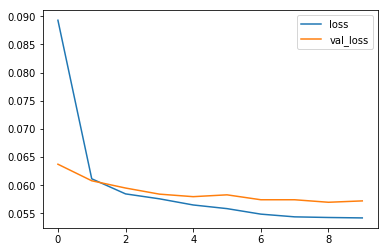

In [29]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

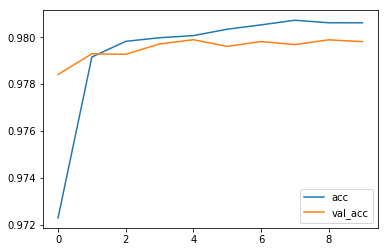

In [30]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [31]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.971451086125632


In [32]:
# Bidirectional

In [33]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

Building model...


In [34]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 109s 857us/step - loss: 0.0693 - acc: 0.9768 - val_loss: 0.0577 - val_acc: 0.9801
Epoch 2/10
127656/127656 [==============================] - 110s 860us/step - loss: 0.0551 - acc: 0.9804 - val_loss: 0.0548 - val_acc: 0.9808
Epoch 3/10
127656/127656 [==============================] - 110s 865us/step - loss: 0.0524 - acc: 0.9811 - val_loss: 0.0537 - val_acc: 0.9808
Epoch 4/10
127656/127656 [==============================] - 111s 871us/step - loss: 0.0506 - acc: 0.9816 - val_loss: 0.0518 - val_acc: 0.9811
Epoch 5/10
127656/127656 [==============================] - 111s 867us/step - loss: 0.0497 - acc: 0.9819 - val_loss: 0.0517 - val_acc: 0.9812
Epoch 6/10
127656/127656 [==============================] - 108s 848us/step - loss: 0.0490 - acc: 0.9820 - val_loss: 0.0514 - val_acc: 0.9815
Epoch 7/10
127656/127656 [==============================] - 101s 792us/step - l

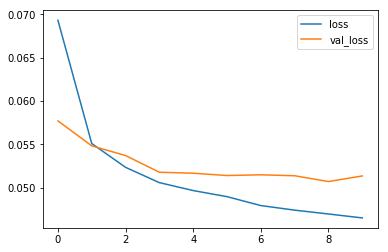

In [35]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

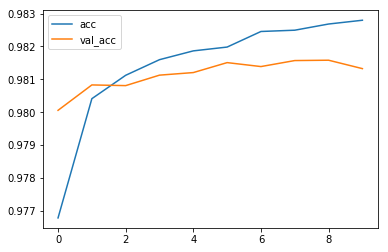

In [36]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [37]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9824441313907509
